<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#File-Config" data-toc-modified-id="File-Config-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>File Config</a></span></li><li><span><a href="#Simulation-Config" data-toc-modified-id="Simulation-Config-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Simulation Config</a></span></li></ul></li><li><span><a href="#Generate-Dataset" data-toc-modified-id="Generate-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate Dataset</a></span></li><li><span><a href="#Save-Sample-or-Read-In" data-toc-modified-id="Save-Sample-or-Read-In-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Save Sample or Read In</a></span></li><li><span><a href="#Run-Model" data-toc-modified-id="Run-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run Model</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Customers-Join" data-toc-modified-id="Customers-Join-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Customers Join</a></span></li><li><span><a href="#Site-Join" data-toc-modified-id="Site-Join-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Site Join</a></span></li><li><span><a href="#GMM" data-toc-modified-id="GMM-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>GMM</a></span></li></ul></li><li><span><a href="#Performance" data-toc-modified-id="Performance-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Performance</a></span></li><li><span><a href="#Viz" data-toc-modified-id="Viz-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Viz</a></span></li></ul></div>

# Generate nNPS data #


The purpose of this notebook is to create a dummy dataset for modelling network NPS. It simulates interactions between customers and the mobile network based on empirical distributions. This can be graphically represented by a bipartite graph having a set of nodes for sites $S_N$ and a set of nodes for customers $C_K$. To generate data from the simulation we follow these steps: 

1. for each site sample an average daily site performance KPI $x_N$,
2. for each site sample a number of daily surveyed customer interactions $D_N$,
3. for each number of connections in $D_N$ sample a random customer id from $C_K$,
4. for each customer $C_K$ determine p(*hadBadInteraction*),
5. for each customer $C_K$ add noise to determine p(*isDetractor*).

## Setup

### Imports

In [1]:
# %matplotlib notebook

import csv
import os
import json
import pandas as pd
import numpy as np
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

from sklearn.metrics import classification_report, auc, confusion_matrix, roc_curve
from math import floor

from pathlib import Path

### File Config

In [2]:
data_dir = Path('./data/')
data_dir.mkdir(exist_ok=True)

input_data_dir = Path('./data/input/')
if not input_data_dir.exists():
    input_data_dir.mkdir()

output_data_dir = Path('./data/output/')
if not output_data_dir.exists():
    output_data_dir.mkdir()

dataset_filename = 'dataset.csv'
dataset_path = input_data_dir/dataset_filename

responses_filename = 'responses.csv'
responses_path = input_data_dir/responses_filename

kpis_filename = 'kpis.csv'
kpis_path = input_data_dir/kpis_filename

labels_filename = 'labels.csv'
labels_path = input_data_dir/labels_filename

customer_results_filename = 'customer-results.csv'
customer_results_path = output_data_dir/customer_results_filename

sites_results_filename = 'sites-results.csv'
sites_results_path = output_data_dir/sites_results_filename

gmm_results_filename = 'gmm-results.csv'
gmm_results_path = output_data_dir/gmm_results_filename

weights_results_filename = 'weights-results.csv'
weights_results_path = output_data_dir/weights_results_filename

### Simulation Config

In [3]:
num_customers = 1000
avg_subs_per_site = 3 # used for the Poisson distribution per day
num_days = 30
num_sites = 50

weight_class_0 = 0.8 # ratio of customers from the promoter cluster 
weight_class_1 = 0.2 # ratio of customers from the detractor cluster 

p_error = 0.1 # we use the binary symetric channel to add noise.
               # This is the percentage false promoters and false detractors

resample = True
viz = False

## Generate Dataset

KPI dataset shape: (1500, 3)


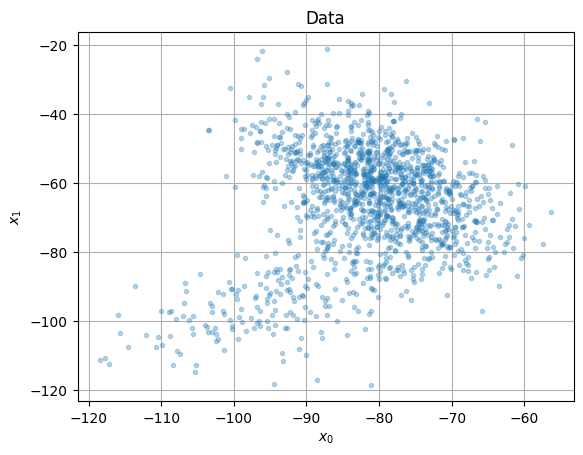

In [4]:
N = num_days*num_sites # number of daily sites (i.e., days*sites)

true_mean_0 = [-80, -60]

true_cov_0 = [[60, -40],
              [-40, 120]]

true_mean_1 = [-70, -70]

true_cov_1 = [[20, 15],
              [15, 60]]

true_mean_2 = [-90, -89]

true_cov_2 = [[150, 90],
              [90, 120]]

true_mean_3 = [-115, -100]

true_cov_3 = [[95, 10],
              [10, 12]]

def sample(component):
    if component == 0:
        a = np.random.multivariate_normal(true_mean_0, true_cov_0, 1).T
        b = np.random.multivariate_normal(true_mean_1, true_cov_1, 1).T
        ind = np.random.choice([0, 1], 1, p=[1, 0])
        return np.array([a, b])[ind].reshape(1, 2)
    if component == 1:
        a = np.random.multivariate_normal(true_mean_2, true_cov_2, 1).T
        b = np.random.multivariate_normal(true_mean_3, true_cov_3, 1).T
        ind = np.random.choice([0, 1], 1, p=[1, 0])
        return np.array([a, b])[ind].reshape(1, 2)

# comp 0 = good, comp 1 = bad
mask = np.random.choice([0, 1], N, p=[weight_class_0, weight_class_1])
kpi_data = [sample(i) for i in mask]
kpi_data = np.array(kpi_data).reshape(N, 2)
df_kpi = pd.DataFrame(kpi_data, columns=['x0', 'x1'])
df_kpi['comp'] = mask
print("KPI dataset shape: {}".format(df_kpi.shape))

plt.plot(df_kpi['x0'],
         df_kpi['x1'],
         '.',
         label='data',
         alpha=0.3)

plt.title("Data")
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.grid()
plt.show()

In [5]:
df_kpi.groupby('comp').mean()

,x0,x1
comp,,
0,-80.070777,-60.101189
1,-89.048426,-89.131963


Create a few semi-supervised labels.

In [6]:
df_good_kpis = df_kpi[(df_kpi['x0'] > -80) & (df_kpi['x1'] > -60)]
df_bad_kpis = df_kpi[(df_kpi['x0'] < -100) & (df_kpi['x1'] < -100)]
df_good_kpis.shape, df_bad_kpis.shape

((228, 3), (28, 3))

In [7]:
num_labels = 10
df_kpi['label'] = 100000 #NAN Value
good_ids = df_good_kpis.sample(n=num_labels).index.values
bad_ids = df_bad_kpis.sample(n=num_labels).index.values
df_kpi.loc[good_ids, 'label'] = 0
df_kpi.loc[bad_ids, 'label'] = 1

df_labels = df_kpi['label']

df_kpi[df_kpi['label']==0].shape, df_kpi[df_kpi['label']==1].shape

((10, 4), (10, 4))

For each site, sample a daily degree.

In [8]:
# Note: this is the daily site degree distribution.
D = np.random.poisson(avg_subs_per_site, N)
D.shape

(1500,)

In [9]:
# plt.hist(D, 100, alpha=0.4, color='gray')
# plt.grid()
# plt.xlabel('Degree distribution')
# plt.title('Daily site degree distribution')
# plt.show()

We have N number of daily sites for which each daily site needs to be uniformly allocated to customers.

In [10]:
customer_ids = list(range(num_customers))
daily_site_ids = list(range(N))
cust_site_dict = {}

for i in daily_site_ids:
    num_customer_connections = D[i]
    np.random.shuffle(customer_ids)
    ids = customer_ids[:num_customer_connections]
    for j in ids:
        if j in cust_site_dict:
            temp_list = cust_site_dict[j]
            temp_list.append(i)
            cust_site_dict.update({j:temp_list})
        else:
            cust_site_dict.update({j:[i]})        

In [11]:
# test uniqueness
# for k, v in cust_site_dict.items():
#     if len(v) != len(set(v)):
#         print(k)

In [12]:
df_temp = pd.DataFrame.from_dict(cust_site_dict, orient='index')

In [13]:
df_temp.sort_index(inplace=True)

In [14]:
kpis = []
comp = []
hadBadInteraction = []

for index, row in df_temp.iterrows():
    x = row.values
    ids = x[~np.isnan(x)].astype(int)
    kpis.append(df_kpi.loc[ids, 'x0':'x1'].values.round(2).tolist())

    comp.append(df_kpi.loc[ids, 'comp'].values)
    # deterministic OR logic
    hadBadInteraction.append(np.any(df_kpi.loc[ids, 'comp']))

In [15]:
# y = list(map(lambda x: 1 if x else 0, hadBadInteraction))
# plt.hist(y, 10)
# plt.grid()
# plt.xlabel('$p(hadBadInteraction)$')
# plt.show()

In [16]:
df_temp['kpis'] = kpis
df_temp['component'] = comp
df_temp['hadBadInteraction'] = hadBadInteraction

In [17]:
df_customers = df_temp.loc[:, :'kpis'].drop(['kpis'], axis=1)

In [18]:
df_customers = df_customers.apply(lambda x: list(x[~np.isnan(x)].astype(int)), axis=1)

In [19]:
df_customers = pd.DataFrame(df_customers, columns=['temp'])

In [20]:
df_customers['site_ids'] = [','.join(map(str, l)) for l in df_customers['temp']]

In [21]:
df_temp.shape, df_customers.shape

((987, 15), (987, 2))

In [22]:
df_customers['hadBadInteraction'] = df_temp['hadBadInteraction'].astype(int)
df_customers['isDetractor'] = df_customers['hadBadInteraction']

# hadBadSiteInt, isDetractor, p(isDetractor|hadBadSiteInt)
# 0              0            1 - p(error)
# 0              1            p(error)
# 1              0            p(error)
# 1              1            1 - p(error)

mask = df_customers[df_customers['hadBadInteraction'] == 0].sample(frac=p_error).index.values
df_customers.loc[mask, 'isDetractor'] = 1
mask = df_customers[df_customers['hadBadInteraction'] == 1].sample(frac=p_error).index.values
df_customers.loc[mask, 'isDetractor'] = 0

## Save Sample or Read In

Create dataset.csv file, which has number of customers as rows and jagged daily site ids as columns.

In [23]:
if resample:
    config = {'num_customers' :num_customers,
          'avg_subs_per_site' :avg_subs_per_site,
          'num_days' :num_days,
          'num_sites' :num_sites,
          'weight_class_0' :weight_class_0,
          'weight_class_1' :weight_class_1}
    with open(data_dir/'config.json', 'w') as fp:
        json.dump(config, fp)
    df_customers.to_pickle(data_dir/'df_customers.pck')
    df_kpi.to_pickle(data_dir/'df_kpi.pck')
    df_temp.to_pickle(data_dir/'df_temp.pck') 

In [24]:
with open(data_dir/'config.json', 'r') as fp:
    config = json.load(fp)
num_customers = config['num_customers']
avg_subs_per_site = config['avg_subs_per_site']
num_days = config['num_days']
num_sites = config['num_sites']

weight_class_0 = config['weight_class_0']
weight_class_1 = config['weight_class_1']

In [25]:
# Don't quite trust the dropna here, for some reason subs get dropped
# Causing a missalignment in joining the results
df_customers = pd.read_pickle(data_dir/'df_customers.pck').\
dropna().\
reset_index().\
drop('index', axis=1)

df_customers.\
site_ids.\
str.\
replace(',', ';').\
to_csv(dataset_path, 
       sep=',', 
       quoting=csv.QUOTE_NONE,
       header=False, 
       index=False)


Create kpis.csv file, which has number of days multiplied with number of unique sites equal to the number of rows.

In [26]:
df_kpi = pd.read_pickle(data_dir/'df_kpi.pck')
df_kpi.loc[:,'x0':'x1'].to_csv(kpis_path, 
decimal = ',',
                               sep=';', 
                               header=False, 
                               index=False)

Create responses.csv file, which has number of customers as rows.

In [27]:
df_customers[['isDetractor']].\
to_csv(responses_path, 
       sep='|', 
       header=False, 
       index=True)

Create labels.csv file, which has the semi-supervised labels as rows.

In [28]:
df_labels.to_csv(labels_path, 
                 sep=',', 
                 header=False, 
                 index=False)

## Run Model

In [29]:
dotnet_cmd = f'dotnet run --project ../model/pgm '
args = f'../notebooks/{data_dir}/ {dataset_filename} {responses_filename} {kpis_filename} {labels_filename} {num_days} {num_sites}'
cmd = dotnet_cmd + args
print(cmd)

dotnet run --project ../model/pgm ../notebooks/data/ dataset.csv responses.csv kpis.csv labels.csv 30 50


In [30]:
!{cmd}

===--------------------------------------------------------
Maximum site id found: 1499, total array size: 1500
Number of days: 30
Number of unique sites: 50
Total number of customers (from data file): 987
Total number of customers (from nps file): 987
Compiling model...done.
Iterating: 
.........|.........|.........| 30
Posterior Gaussian: VectorGaussian(-79,85 -59,86, 0,05091  -0,03492)
                              -0,03492 0,1119  
Posterior Gamma: 60,47  -41,89
-41,89 125,2
Posterior Gaussian: VectorGaussian(-80,11 -75,39, 0,0967  0,09032)
                              0,09032 0,4865 
Posterior Gamma: 198,2 195,1
195,1 309,8
True detractor: Beta(533,9,70,22)[mean=0,8838]
False detractor: Beta(24,09,372,7)[mean=0,06071]
Weights: Beta(271,4,953,8)[mean=0,2215]
=

## Results

### Customers Join

In [31]:
df_customers_results = pd.read_csv(customer_results_path, 
                                   header=None, 
                                   sep=';',
                                   decimal=',',
                                   names=['customer_id',
                                          'hadBadSiteInter'])
df_customers_results['hadBadSiteInter'] = df_customers_results['hadBadSiteInter'].astype(str).replace(',','.').apply(lambda x: float(x))

In [32]:
assert df_customers_results.shape[0] == df_customers.shape[0], 'need to have the same amount of customers'

In [33]:
df_customers_results = pd.concat([df_customers, 
                                  df_customers_results], 
                                 axis=1).\
reset_index().\
rename(columns={'index':'cust_id'})

In [34]:
assert df_customers_results.isna().sum().sum() == 0, 'There shouldn \'t be missing values here'

In [35]:
# df_customers_results.sample(10)

### Site Join

In [36]:
df_sites_results = pd.read_csv(sites_results_path, 
                               sep=';',
                               header=None, 
                               names=['hadBadPerf'])
df_sites_results.hadBadPerf = df_sites_results.hadBadPerf.astype(str).str.replace(',','.').apply(lambda x: float(x))

In [37]:
assert df_kpi.shape[0] == df_sites_results.shape[0], 'need to have the same amount of sites'

In [38]:
df_kpi.shape, df_sites_results.shape

((1500, 4), (1500, 1))

In [39]:
df_sites_results = pd.concat([df_kpi, df_sites_results], axis=1).\
reset_index().rename(columns={'index':'site_id'})

In [40]:
assert df_sites_results.isna().sum().sum() == 0, 'There shouldn \'t be missing values here'

### GMM

In [41]:
df_gmm_results = pd.read_csv(gmm_results_path, header=None, names=['mean0',
                                                                   'mean1',
                                                                   'var0',
                                                                   'var1',
                                                                   'var2',
                                                                   'var3'], sep=';')

In [42]:
df_gmm_results

,mean0,mean1,var0,var1,var2,var3
0,"-79,85496907769225","-59,86263048612523","60,47427157796554","-41,88632366881703","-41,88632366881703","125,18432278019584"
1,"-80,10757781871578","-75,39358734506956","198,2021665416891","195,11091012490257","195,11091012490257","309,75716234163247"


In [43]:
# df_weights_results = pd.read

In [44]:
# w_detractors = df_weights_results.loc[0,'weights']
# w_detractors

In [45]:
# df_gmm_results.dtypes

In [46]:
df_gmm_results

,mean0,mean1,var0,var1,var2,var3
0,"-79,85496907769225","-59,86263048612523","60,47427157796554","-41,88632366881703","-41,88632366881703","125,18432278019584"
1,"-80,10757781871578","-75,39358734506956","198,2021665416891","195,11091012490257","195,11091012490257","309,75716234163247"


In [47]:
df_gmm_results['mean0'] = df_gmm_results['mean0'].astype(str).str.replace(',','.').astype(float)
df_gmm_results['mean1'] = df_gmm_results['mean1'].astype(str).str.replace(',','.').astype(float)
df_gmm_results['var0'] = df_gmm_results['var0'].astype(str).str.replace(',','.').astype(float)
df_gmm_results['var1'] = df_gmm_results['var1'].astype(str).str.replace(',','.').astype(float)
df_gmm_results['var2'] = df_gmm_results['var2'].astype(str).str.replace(',','.').astype(float)
df_gmm_results['var3'] = df_gmm_results['var3'].astype(str).str.replace(',','.').astype(float)

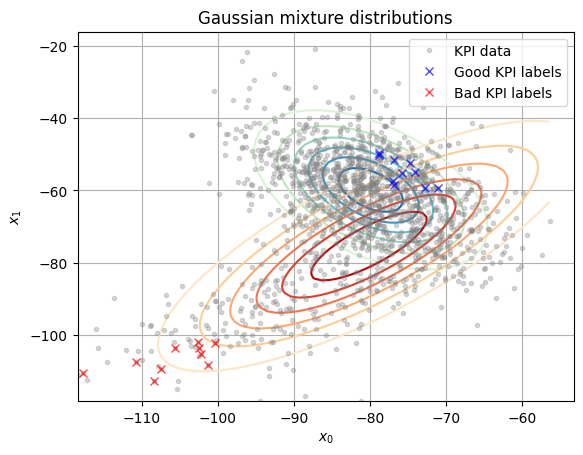

In [48]:

fig = plt.figure()
ax = fig.add_subplot(111)
x0_min = df_sites_results['x0'].min()
x0_max = df_sites_results['x0'].max()
x1_min = df_sites_results['x1'].min()
x1_max = df_sites_results['x1'].max()

x, y = np.mgrid[x0_min:x0_max:1, x1_min:x1_max:1]

pos = np.dstack((x, y))

ax.plot(df_sites_results['x0'],
        df_sites_results['x1'],
        '.',
        label='KPI data',
        color='gray',
        alpha=0.3)
ax.plot(df_sites_results[df_sites_results['label'] == 0]['x0'],
        df_sites_results[df_sites_results['label'] == 0]['x1'],
        'x',
        label='Good KPI labels',
        color='blue',
        alpha=0.7)
ax.plot(df_sites_results[df_sites_results['label'] == 1]['x0'],
        df_sites_results[df_sites_results['label'] == 1]['x1'],
        'x',
        label='Bad KPI labels',
        color='red',
        alpha=0.7)

for index, row in df_gmm_results.iterrows():
    mean = np.array([row['mean0'], row['mean1']])
    prec = np.array([[row['var0'], row['var1']], 
                     [row['var2'], row['var3']]])
    rv = multivariate_normal(mean, prec)
    if index == 0:
        ax.contour(x, y, rv.pdf(pos),cmap='GnBu')
    else:
        ax.contour(x, y, rv.pdf(pos), cmap='OrRd')
plt.grid()
plt.legend()
plt.title("Gaussian mixture distributions")
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")
plt.show()       


## Performance

In [49]:
cust_threshold = 0.5
cust_y_true = list(df_customers_results.isDetractor)
cust_y_pred = [int(v > cust_threshold) for v in list(df_customers_results.hadBadSiteInter)]
target_names = ['promotors', 'detractors']
print(confusion_matrix(cust_y_true, cust_y_pred))
print(classification_report(cust_y_true, cust_y_pred, target_names=target_names))

[[386  50]
 [ 15 536]]
              precision    recall  f1-score   support

   promotors       0.96      0.89      0.92       436
  detractors       0.91      0.97      0.94       551

    accuracy                           0.93       987
   macro avg       0.94      0.93      0.93       987
weighted avg       0.94      0.93      0.93       987



In [50]:
site_threshold = 0.5
site_y_true = list(df_sites_results.comp)
site_y_pred = [int(v > site_threshold) for v in list(df_sites_results.hadBadPerf)]
target_names = ['good', 'bad']
print(confusion_matrix(site_y_true, site_y_pred))
print(classification_report(site_y_true, site_y_pred, target_names=target_names))

[[1185   31]
 [  29  255]]
              precision    recall  f1-score   support

        good       0.98      0.97      0.98      1216
         bad       0.89      0.90      0.89       284

    accuracy                           0.96      1500
   macro avg       0.93      0.94      0.94      1500
weighted avg       0.96      0.96      0.96      1500



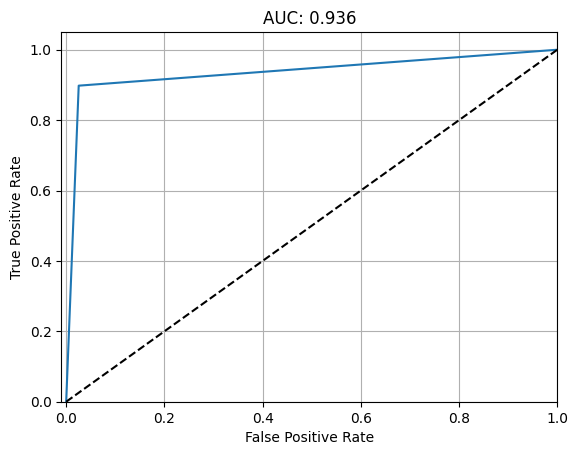

In [51]:
fpr, tpr, _ = roc_curve(site_y_true, site_y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.title("AUC: {0:.3f}".format(roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

## Viz

In [52]:
cust_y = -1*(num_days)
site_y = 1
num_customers = df_customers_results.shape[0]

if num_sites > num_customers:
    x_offset = (num_sites-num_customers)/2
else:
    x_offset = -1*((num_customers-num_sites)/2)
    
nnps_colors = list(px.colors.diverging.RdYlGn_r)

In [54]:
if viz:
    fig = go.Figure()

    # Plot Sites
    all_site_ids = list(df_sites_results.site_id.values)
    all_bad_perf = list(df_sites_results.hadBadPerf.values)
    for day in range(0, num_days):
        adj_site_ids = all_site_ids[num_sites*day:num_sites*(day+1)]
        site_ids = [s%num_sites for s in adj_site_ids]
        i = 0
        for bad_perf, site_id in zip(all_bad_perf, site_ids):
            site_df = df_sites_results[df_sites_results.site_id == site_id + num_sites*day]
            site_x = site_df.x0.values[0]
            site_comp = site_df.comp.values[0]
            fig.add_trace(
                go.Scatter(x=[site_id], 
                           y=[site_y*(day+1)], 
                           mode='markers',
                           showlegend=i==0,
                           name=f'Sites on day {day}',
                           legendgroup=f'day_{day}',
                           marker=dict(color=nnps_colors[int(bad_perf*10)]),
                           hovertemplate = 'Site: %{x} <br>Day: %{y} <br>had bad perf:' + 
                           f'{bad_perf}'+
                           f'<br>x = {site_x}<br>comp = {site_comp}'))
            i = i+1
    for i, cust in df_customers_results.iterrows():
        # Plot Customers
        x = cust.cust_id
        fig.add_trace(go.Scatter(x=[x+x_offset], 
                                 y=[cust_y], 
                                 mode='markers', 
                                 marker=dict(color=nnps_colors[int(cust.hadBadSiteInter*10)]),
                                 legendgroup=f'cust_{x}',
                                 hovertemplate = f'Customer: {x}'+
                                 f'<br>had bad site interactions: %{str(cust.hadBadSiteInter)}'+
                                 f'<br>isDetractor: {cust.isDetractor}',
                                 text = cust.hadBadSiteInter,
                                 name=f'Customer {x}'))
        # Plot Connections
        connected_sites = cust.temp
        for site in connected_sites:
            site_id = site%num_sites
            site_day = floor(site/num_sites)
            fig.add_trace(go.Scatter(x=[x+x_offset, site_id],
                                     showlegend=False,
                                     legendgroup=f'cust_{x}',
                                     opacity=0.1,
                                     line={'color':'#aaa', 'width':1},
                                     mode='lines',
                                     y=[cust_y, (site_day+1)*site_y]))
    fig.update_xaxes(showgrid=False, zeroline=False, range=[min(x_offset, 0)-1, max(num_sites, num_customers/1.8)+1], showticklabels=False)
    fig.update_yaxes(showgrid=False, zeroline=False, range=[min(cust_y, site_y)-1, num_days+1], showticklabels=False)
    fig.update_layout(template='plotly_dark', height=600)
    fig.show()